# Задача 

Обучить кодировщик помещать похожие лица рядом.

# Решение

## Среда

In [76]:
#@title Библиотеки
import os
import sys
import random as random
import matplotlib.pyplot as plt 
import matplotlib.image as matimg
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
from IPython.display import clear_output, Image as ImagePy 
from PIL import Image 
import imageio 
import time
import datetime
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.models import *
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing import image # для отрисовки изображения
from tensorflow.keras.optimizers import Adam # загружаем выбранный оптимизатор
from tensorflow.keras import utils # загружаем утилиты кераса
from sklearn.model_selection import train_test_split
import json
from tqdm import tqdm 

In [77]:
#@title Параметры
DATA_PATH = 'data' # основной каталог для сохранения и загрузки данных
FACE_PATH = os.path.join(DATA_PATH, 'imgs') # каталог сохранения загрузки фото
COUNT_FACE = 100 # количество скачиваемых фото одного актера
NORM_PATH = os.path.join(DATA_PATH, 'norm100') # каталог сохранения нормализованного фото
SHAPE_IN = (100, 100, 3)  # размер нормализации
HIDDEN = 3 # размер скрытого пространства кодировщика
MARGIN = 1000 # ошибка расстояния сиамской сети
EPS = 100 # количество эпох финального обучения
BATCH = 32 # размер партий обучения
SIZE_DATASET = 7000 # финальный размер выборки 
VALID_SIZE = 0.2 # процент проверочных данных
TEST_SIZE = 0.2 # процент тестовых данных
COUNT_EXP = 1000 # кол-во экспортируемых фото 
PATH_EXP = os.path.join(DATA_PATH, 'fake')
FILE_EXP = os.path.join(DATA_PATH, 'fake.csv')

## Датасет

In [78]:
#@title Список актеров
with open('actors.json', 'r') as fp:
    dict_act = json.load(fp)
dict_act

{'women': ['Alicia Vikander',
  'Amy Adams',
  'Andie MacDowell',
  'Angelina Jolie',
  'Anne Hathaway',
  'Cameron Diaz',
  'Carey Mulligan',
  'Cate Blanchett',
  'Catherine Zeta-Jones',
  'Charlize Theron',
  'Claire Forlani',
  'Demi Moore',
  'Drew Barrymore',
  'Elizabeth Taylor',
  'Emma Stone',
  'Eva Mendes',
  'Frances McDormand',
  'Gwyneth Paltrow',
  'Halle Berry',
  'Hilary Swank',
  'Jennifer Aniston',
  'Jessica Biel',
  'Jessica Chastain',
  'Jodie Foster',
  'Julia Roberts',
  'Julianne Moore',
  'Juliette Binoche',
  'Kate Winslet',
  'Keira Knightley',
  'Kim Basinger',
  'Kirsten Dunst',
  'Kristin Scott Thomas',
  "Lupita Nyong'o",
  'Maggie Gyllenhaal',
  'Marion Cotillard',
  'Meg Ryan',
  'Megan Fox',
  'Melanie Laurent',
  'Meryl Streep',
  'Michelle Pfeiffer',
  'Milla Jovovich',
  'Naomi Watts',
  'Natalie Portman',
  'Natasha Henstridge',
  'Nicole Kidman',
  'Nina Dobrev',
  'Octavia Spencer',
  'Penélope Cruz',
  'Rachel McAdams',
  'Reese Witherspoon',
 

In [5]:
#@title Парсинг фото
filters = "+filterui:imagesize-large+filterui:color2-color+filterui:photo-photo+filterui:aspect-square+filterui:face-face"
for key in list(dict_act.keys()):
    print(key)
    for face in tqdm(dict_act[key]):
        os.system(f'python bbid.py -s "{face}" -o "{os.path.join(FACE_PATH, face)}" --filters {filters} --limit {COUNT_FACE}')

women


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [17:18<00:00, 17.03s/it]


men


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [19:53<00:00, 16.13s/it]


### Нормализация

In [79]:
#@title Обрезка краев
def crop_img(i, h=320, w=320):
    k = i.size[0]/i.size[1] # разница высоты и ширины
    i = i.resize((int(w*k) if k > 1 else w, int(h/k) if k < 1 else h))
    x1, y1 = (w + (i.size[0]-w)//2, 0) if k > 1 else (0, h+(i.size[1]-h)//2)
    x2, y2 = ((i.size[0]-w)//2, h) if k > 1 else (w, (i.size[1]-h)//2)
    i = i.crop(([x1,x2][k>1], [y1,y2][k<=1], [x1,x2][k<=1], [y1,y2][k>1]))
    return np.array(i)
#@title Расширение краев
def extend_img(i, h=320, w=320):
    k = i.size[0]/i.size[1] # разница высоты и ширины
    bg = Image.new('RGB', (i.size[k<1], i.size[k<1]), (0, 0, 0))
    img_w, img_h = i.size
    bg_w, bg_h = bg.size
    offset = ((bg_w - img_w) // 2, (bg_h - img_h) // 2)
    bg.paste(i, offset)
    i = bg.resize((w, h))
    return np.array(i)

In [70]:
#@title Сохранение фото
if not os.path.exists(NORM_PATH): os.mkdir(NORM_PATH)
i = 0
for key in list(dict_act.keys()):
    for face in dict_act[key]:
        path = FACE_PATH + os.path.sep + face
        imgs_fnames = os.listdir(path) # получим список изображений 
        for j, fname in tqdm(enumerate(imgs_fnames)): 
            fname = os.path.join(path, fname)
            try:
                arr = Image.open(fname)
                k = arr.size[0]/arr.size[1] # разница высоты и ширины
                if k < 0.9 or k > 1.1:
                    norm = crop_img(arr, *SHAPE_IN[:2])
                else:
                    norm = extend_img(arr, *SHAPE_IN[:2])
                im = Image.fromarray(norm)
                dname = os.path.join(NORM_PATH, face)
                if not os.path.exists(dname): os.mkdir(dname)
                im.save(dname + os.path.sep+ f'{j:03d}.jpg')
                i += 1
            except Exception as er:
                print(er)
print('total count face', i)

41it [00:01, 39.60it/s]

cannot identify image file 'data\\imgs\\Alicia Vikander\\Alicia-Vikander'


97it [00:02, 36.75it/s]
53it [00:01, 53.35it/s]

cannot identify image file 'data\\imgs\\Amy Adams\\Amy-Adams'


100it [00:02, 40.33it/s]
54it [00:01, 31.15it/s]

cannot identify image file 'data\\imgs\\Andie MacDowell\\Andie-MacDowell'


100it [00:02, 43.50it/s]
12it [00:00, 30.87it/s]

cannot write mode RGBA as JPEG


47it [00:01, 39.70it/s]

cannot write mode RGBA as JPEG


100it [00:03, 26.94it/s]
99it [00:03, 28.02it/s]
100it [00:02, 36.65it/s]
48it [00:01, 49.98it/s]

cannot identify image file 'data\\imgs\\Carey Mulligan\\Carey-Mulligan'


99it [00:02, 39.17it/s]
100it [00:03, 33.07it/s]
98it [00:02, 39.95it/s]
12it [00:00, 36.91it/s]C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
88it [00:02, 41.99it/s]
50it [00:00, 83.50it/s]

cannot identify image file 'data\\imgs\\Claire Forlani\\Claire-Forlani'


95it [00:01, 56.48it/s]

cannot write mode RGBA as JPEG
cannot write mode RGBA as JPEG


100it [00:01, 59.49it/s]
32it [00:00, 38.63it/s]

cannot identify image file 'data\\imgs\\Demi Moore\\Demi-Moore'


73it [00:01, 38.33it/s]


cannot write mode RGBA as JPEG


49it [00:01, 36.94it/s]

cannot identify image file 'data\\imgs\\Drew Barrymore\\Drew-Barrymore'


100it [00:02, 34.70it/s]
46it [00:01, 38.35it/s]

cannot write mode RGBA as JPEG


100it [00:02, 41.69it/s]
100it [00:03, 33.06it/s]
99it [00:02, 41.47it/s]
33it [00:00, 33.86it/s]
100it [00:02, 36.79it/s]
27it [00:01, 35.07it/s]

cannot write mode RGBA as JPEG


100it [00:03, 28.41it/s]
57it [00:01, 44.83it/s]

cannot identify image file 'data\\imgs\\Hilary Swank\\Hilary-Swank'


100it [00:02, 41.23it/s]
56it [00:01, 38.63it/s]

cannot identify image file 'data\\imgs\\Jennifer Aniston\\Jennifer-Aniston'


100it [00:03, 28.95it/s]
100it [00:02, 40.36it/s]
100it [00:02, 39.85it/s]
59it [00:01, 36.27it/s]

cannot identify image file 'data\\imgs\\Jodie Foster\\Jodie-Foster'


100it [00:02, 36.95it/s]
9it [00:00, 25.03it/s]

cannot write mode RGBA as JPEG


59it [00:01, 39.68it/s]

cannot identify image file 'data\\imgs\\Julia Roberts\\Julia-Roberts'


100it [00:02, 33.99it/s]
67it [00:01, 52.31it/s]

cannot identify image file 'data\\imgs\\Julianne Moore\\Julianne-Moore'
cannot identify image file 'data\\imgs\\Julianne Moore\\Julianne-Moore---The-Hunger-Games'


79it [00:01, 46.90it/s]

cannot write mode RGBA as JPEG


100it [00:02, 45.55it/s]
79it [00:01, 54.38it/s]
82it [00:02, 43.80it/s]

cannot write mode RGBA as JPEG


100it [00:02, 41.98it/s]
32it [00:00, 38.50it/s]

cannot write mode RGBA as JPEG


100it [00:02, 36.17it/s]
25it [00:00, 58.04it/s]

cannot write mode RGBA as JPEG


100it [00:01, 61.48it/s]
100it [00:02, 36.43it/s]
70it [00:01, 52.01it/s]

cannot identify image file 'data\\imgs\\Kristin Scott Thomas\\Kristin-Scott-Thomas'


98it [00:02, 44.12it/s]
100it [00:02, 38.30it/s]
57it [00:01, 50.66it/s]

cannot identify image file 'data\\imgs\\Maggie Gyllenhaal\\Maggie-Gyllenhaal'


99it [00:02, 40.52it/s]
100it [00:01, 59.35it/s]
91it [00:02, 41.11it/s]
100it [00:02, 33.54it/s]
65it [00:01, 39.96it/s]

cannot write mode RGBA as JPEG


100it [00:02, 36.89it/s]
46it [00:01, 33.62it/s]
100it [00:02, 39.99it/s]
36it [00:00, 50.83it/s]

cannot write mode RGBA as JPEG


100it [00:02, 41.79it/s]
55it [00:01, 37.12it/s]

cannot identify image file 'data\\imgs\\Naomi Watts\\Naomi-Watts'


100it [00:02, 46.71it/s]
52it [00:01, 36.61it/s]

cannot identify image file 'data\\imgs\\Natalie Portman\\https'


88it [00:02, 35.09it/s]

cannot write mode RGBA as JPEG


100it [00:02, 34.47it/s]
100it [00:01, 58.13it/s]
94it [00:02, 39.40it/s]

cannot write mode RGBA as JPEG


100it [00:02, 33.38it/s]
97it [00:02, 34.55it/s]

cannot write mode RGBA as JPEG


100it [00:03, 32.16it/s]
100it [00:02, 48.23it/s]
20it [00:00, 43.80it/s]

cannot write mode RGBA as JPEG
cannot write mode RGBA as JPEG


45it [00:00, 51.62it/s]

cannot write mode RGBA as JPEG


100it [00:02, 40.82it/s]
100it [00:02, 34.31it/s]


cannot write mode RGBA as JPEG


51it [00:01, 29.30it/s]

cannot identify image file 'data\\imgs\\Reese Witherspoon\\Reese-Witherspoon'


100it [00:03, 30.09it/s]
100it [00:02, 40.81it/s]
100it [00:02, 46.41it/s]
93it [00:02, 40.44it/s]

cannot write mode RGBA as JPEG


100it [00:02, 39.95it/s]
88it [00:02, 24.60it/s]

cannot write mode RGBA as JPEG


100it [00:03, 31.66it/s]
100it [00:02, 46.38it/s]
100it [00:02, 37.54it/s]
100it [00:03, 25.97it/s]
55it [00:01, 45.46it/s]

cannot identify image file 'data\\imgs\\Vera Farmiga\\Vera-Farmiga'


65it [00:01, 46.62it/s]
48it [00:02, 20.06it/s]
100it [00:03, 33.17it/s]
100it [00:02, 37.61it/s]
100it [00:02, 40.52it/s]
100it [00:01, 61.85it/s]
99it [00:01, 57.47it/s]
100it [00:03, 29.01it/s]
79it [00:01, 61.19it/s]

cannot write mode RGBA as JPEG


100it [00:01, 50.67it/s]
4it [00:00, 31.93it/s]

cannot write mode RGBA as JPEG


100it [00:01, 50.18it/s]
100it [00:01, 51.67it/s]
99it [00:01, 56.74it/s]
80it [00:01, 54.71it/s]
100it [00:02, 42.88it/s]
100it [00:03, 32.66it/s]
42it [00:00, 47.18it/s]
43it [00:01, 42.20it/s]
43it [00:00, 54.46it/s]

cannot write mode RGBA as JPEG


100it [00:02, 44.30it/s]
100it [00:01, 54.10it/s]
100it [00:02, 43.90it/s]
100it [00:01, 55.84it/s]
28it [00:00, 63.80it/s]

cannot write mode RGBA as JPEG


100it [00:01, 62.64it/s]
77it [00:01, 55.38it/s]
74it [00:01, 44.57it/s]

cannot write mode RGBA as JPEG


100it [00:02, 46.45it/s]


cannot write mode RGBA as JPEG
cannot write mode RGBA as JPEG


20it [00:00, 37.63it/s]

cannot write mode RGBA as JPEG


100it [00:02, 42.36it/s]
100it [00:01, 57.92it/s]
41it [00:00, 42.80it/s]

cannot write mode RGBA as JPEG


100it [00:02, 48.68it/s]
100it [00:01, 51.68it/s]
100it [00:02, 48.72it/s]
100it [00:02, 45.77it/s]
100it [00:01, 57.77it/s]
100it [00:02, 43.76it/s]
100it [00:01, 52.43it/s]
100it [00:03, 31.29it/s]
100it [00:01, 55.43it/s]
100it [00:02, 48.37it/s]
100it [00:02, 45.07it/s]
100it [00:02, 48.90it/s]
69it [00:01, 46.69it/s]

cannot write mode RGBA as JPEG


100it [00:02, 43.40it/s]


cannot write mode RGBA as JPEG


100it [00:01, 51.22it/s]
80it [00:01, 52.08it/s]

cannot write mode RGBA as JPEG


100it [00:02, 43.55it/s]
58it [00:01, 49.54it/s]

cannot identify image file 'data\\imgs\\Jeff Bridges\\https'


100it [00:01, 52.82it/s]

cannot write mode RGBA as JPEG



99it [00:02, 49.44it/s]
100it [00:02, 45.28it/s]
76it [00:01, 68.18it/s]

cannot write mode RGBA as JPEG


100it [00:01, 59.65it/s]
33it [00:00, 52.72it/s]
71it [00:01, 80.96it/s]

cannot write mode RGBA as JPEG


100it [00:01, 55.28it/s]
45it [00:01, 44.30it/s]

cannot write mode RGBA as JPEG


100it [00:02, 44.13it/s]
100it [00:02, 43.02it/s]
100it [00:04, 21.07it/s]
22it [00:00, 48.13it/s]

cannot write mode RGBA as JPEG


100it [00:02, 45.42it/s]
100it [00:02, 34.30it/s]
100it [00:05, 19.53it/s]
100it [00:02, 47.58it/s]
43it [00:01, 29.19it/s]
100it [00:02, 44.25it/s]


cannot write mode RGBA as JPEG


100it [00:01, 66.47it/s]
27it [00:00, 33.18it/s]
100it [00:02, 42.59it/s]


cannot write mode RGBA as JPEG


100it [00:01, 52.54it/s]
44it [00:00, 52.70it/s]
77it [00:01, 48.97it/s]


cannot write mode RGBA as JPEG


48it [00:00, 59.46it/s]

cannot write mode RGBA as JPEG


100it [00:01, 51.26it/s]
25it [00:00, 49.71it/s]

cannot write mode RGBA as JPEG


56it [00:00, 67.34it/s]

cannot write mode RGBA as JPEG


100it [00:01, 62.92it/s]
50it [00:01, 39.05it/s]

cannot write mode RGBA as JPEG


100it [00:03, 30.28it/s]
89it [00:01, 55.69it/s]
27it [00:00, 54.59it/s]

cannot write mode RGBA as JPEG


100it [00:01, 57.82it/s]
100it [00:02, 43.38it/s]
100it [00:01, 56.48it/s]
100it [00:01, 51.98it/s]
100it [00:02, 47.88it/s]
48it [00:00, 48.75it/s]

cannot write mode RGBA as JPEG


94it [00:02, 40.71it/s]
100it [00:01, 51.32it/s]
100it [00:02, 43.71it/s]
19it [00:00, 44.93it/s]

cannot write mode RGBA as JPEG


99it [00:02, 42.60it/s]
80it [00:01, 62.30it/s]
100it [00:02, 44.42it/s]
100it [00:02, 41.91it/s]

cannot write mode RGBA as JPEG
cannot write mode RGBA as JPEG
total count face 12665


In [9]:
#@title Ранжировка выборки        
def shffle_dir_dataset():  
    if os.path.isfile(data_list):
        f = input('Список уже сформирован, 1 - заново?: ')
        if '1' == f:
            os.remove(data_list)
        else: return
    data_list = os.path.join(DATA_PATH, 'data.json')        
    flds = os.listdir(NORM_PATH)
    count = len(flds)
    rnd_fld = random.choices(flds, k=int(TEST_SIZE*count))
    data = {'train': [], 'test': []}
    for fld in flds:
        if fld in rnd_fld:
            data['test'].append(fld)
        else:
            data['train'].append(fld)
    with open(data_list, 'w') as fp:
        json.dump(data, fp)
    return data
shffle_dir_dataset()

{'train': ['Adam Sandler',
  'Al Pacino',
  'Alicia Vikander',
  'Amy Adams',
  'Andie MacDowell',
  'Angelina Jolie',
  'Anthony Hopkins',
  'Antonio Banderas',
  'Arnold Schwarzenegger',
  'Ben Affleck',
  'Ben Foster',
  'Ben Stiller',
  'Brad Pitt',
  'Cameron Diaz',
  'Carey Mulligan',
  'Cate Blanchett',
  'Catherine Zeta-Jones',
  'Charlize Theron',
  'Christian Bale',
  'Clint Eastwood',
  'Cuba Gooding Jr',
  'Daniel Day-Lewis',
  'Demi Moore',
  'Dennis Quaid',
  'Donald Sutherland',
  'Dustin Hoffman',
  'Edward Norton',
  'Elizabeth Taylor',
  'Eva Mendes',
  'Frances McDormand',
  'Gary Oldman',
  'George Clooney',
  'Gerard Butler',
  'Gwyneth Paltrow',
  'Halle Berry',
  'Harrison Ford',
  'Hilary Swank',
  'Hugh Grant',
  'Hugh Jackman',
  'Ian Holm',
  'Jack Black',
  'Jack Nicholson',
  'Jake Gyllenhaal',
  'James McAvoy',
  'Jamie Foxx',
  'Jeff Bridges',
  'Jeff Goldblum',
  'Jennifer Aniston',
  'Jeremy Renner',
  'Jessica Biel',
  'Jessica Chastain',
  'Jim Carrey

In [80]:
#@title Выборки сиамской сети

def process_img(files, y):
    img_a = tf.io.read_file(files[0])
    img_b = tf.io.read_file(files[1])
    img_a = tf.image.decode_jpeg(img_a, channels=3)
    img_b = tf.image.decode_jpeg(img_b, channels=3)
    img_a.set_shape(SHAPE_IN)
    img_b.set_shape(SHAPE_IN)
    img_a = tf.image.convert_image_dtype(img_a, tf.float32)
    img_b = tf.image.convert_image_dtype(img_b, tf.float32)
    print(img_a.shape, img_b.shape)
    return (img_a, img_b), y

def get_data(size=SIZE_DATASET, batch=BATCH, valid_size=VALID_SIZE):
    with open(os.path.join(DATA_PATH, 'data.json'), 'r') as fp:
        train_act = json.load(fp)['train']
    list_dirs = [os.path.join(NORM_PATH, a) for a in train_act]    
    
    half_size = SIZE_DATASET//2
    X, Y = [], [1.]*half_size + [0.]*half_size
    for i in range(half_size):
        actor = random.choice(list_dirs)
        list_face = os.listdir(actor)
        a, b = random.choices(list_face, k=2)
        X.append( (os.path.join(actor, a), os.path.join(actor, b) ) )
         
    for i in range(half_size):
        actor_a, actor_b = random.choices(list_dirs, k=2)
        a_files = os.listdir(actor_a)
        b_files = os.listdir(actor_b)
        a = random.choice(a_files)
        b = random.choice(b_files)
        X.append( (os.path.join( actor_a, a), os.path.join( actor_b, b) ) )
    
    X = np.array(X)
    Y = np.array(Y)
    
    x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=valid_size, shuffle=True) 
    
     
    valid_data  = tf.data.Dataset.from_tensor_slices((x_valid, 
                                                  y_valid))
  
  
    train_data = tf.data.Dataset.from_tensor_slices((x_train, 
                                                  y_train))


    train_gen = train_data.map(lambda x, y: process_img(x, y)).batch(batch)
    valid_gen = valid_data.map(lambda x, y: process_img(x, y)).batch(batch)

    print('All', X.shape, 'train',  x_train.shape, 'valid', x_valid.shape)
    return train_gen, valid_gen

train_gen, valid_gen = get_data()

(100, 100, 3) (100, 100, 3)
(100, 100, 3) (100, 100, 3)
All (7000, 2) train (5600, 2) valid (1400, 2)


## Модель

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_254 (Conv2D)         (None, 98, 98, 64)        1792      
                                                                 
 conv2d_255 (Conv2D)         (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d_162 (MaxPooli  (None, 48, 48, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_256 (Conv2D)         (None, 46, 46, 128)       73856     
                                                                 
 conv2d_257 (Conv2D)         (None, 44, 44, 128)       147584    
                                                                 
 max_pooling2d_163 (MaxPooli  (None, 22, 22, 128)      0         
 ng2D)                                                     

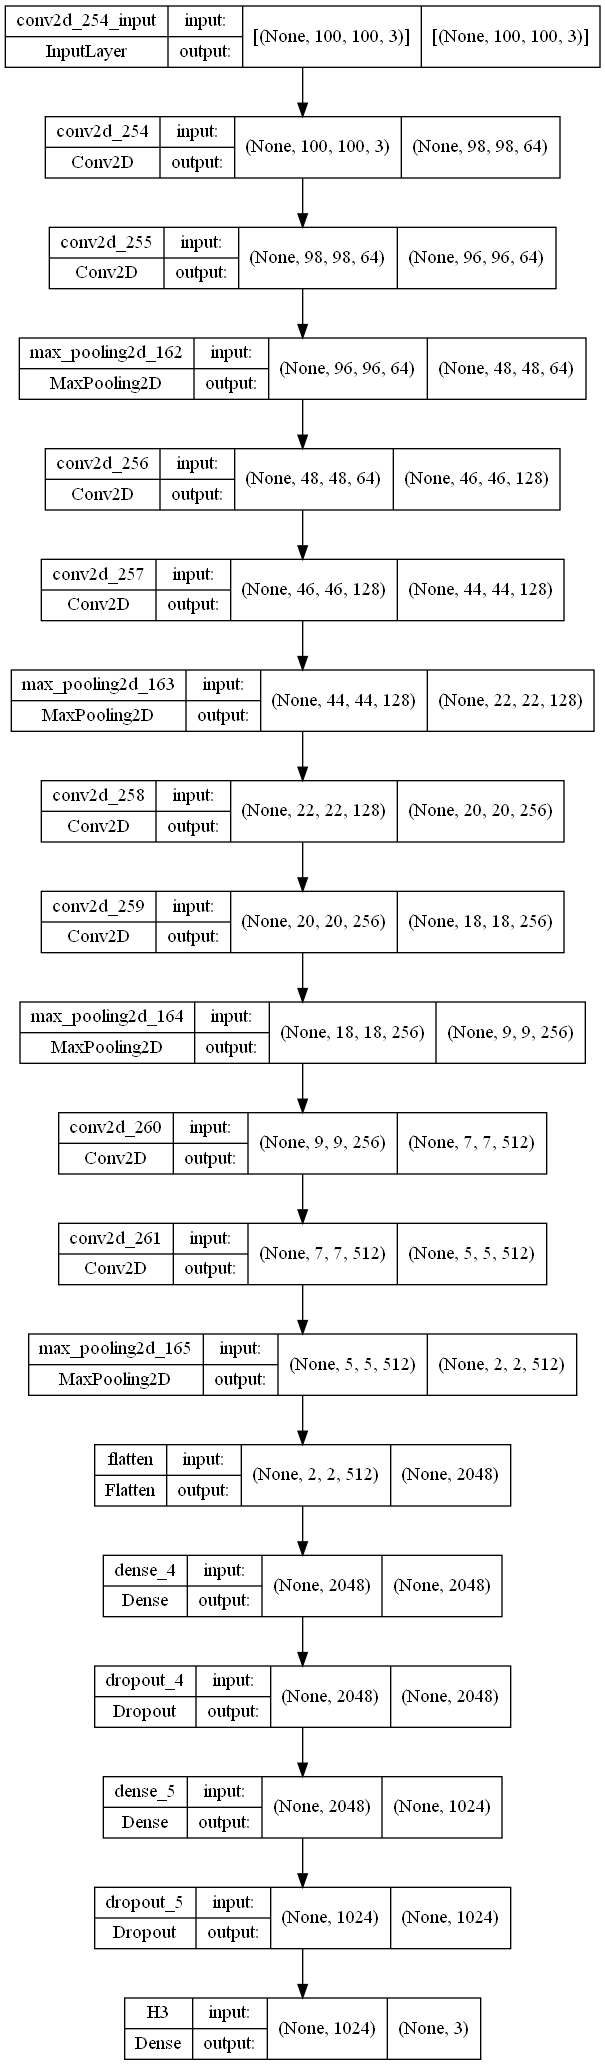

In [89]:
#@title Encoder
def get_encoder(act='relu', dim=3, s=1):  
    return Sequential([
      
     Conv2D(64,  (3, 3), activation=act,  input_shape=SHAPE_IN, strides=s),
     Conv2D(64,  (3, 3), activation=act,  strides=s),
     MaxPooling2D(),
     Conv2D(128,  (3, 3), activation=act,  strides=s),
     Conv2D(128,  (3, 3), activation=act,  strides=s),
     MaxPooling2D(), 
     Conv2D(256,  (3, 3), activation=act,  strides=s),
     Conv2D(256,  (3, 3), activation=act,  strides=s),
     MaxPooling2D(), 
     Conv2D(512,  (3, 3), activation=act,  strides=s),
     Conv2D(512,  (3, 3), activation=act,  strides=s),
     MaxPooling2D(), 
     Flatten(name='flatten'), 
     Dense(2048, activation=act),
     Dropout(0.5),
     Dense(1024, activation=act),
     Dropout(0.5),
     Dense(dim, name='H3'),                    
    ], name='encoder')

m = get_encoder()
print(m.summary())
utils.plot_model(m, dpi=96, show_shapes=True)

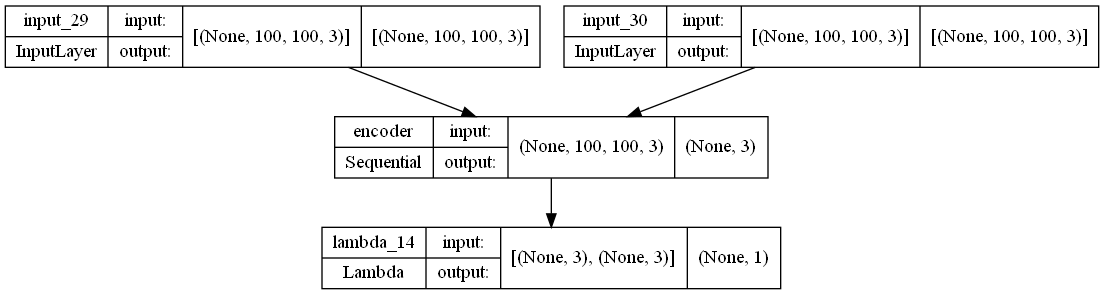

In [82]:
#@title Сиамская нейронная сеть

def get_siam(act='relu', dim=3, lr=0.001):

    img_a = Input(shape=SHAPE_IN)
    img_b = Input(shape=SHAPE_IN)

    encoder = get_encoder(act=act, dim=dim)

    vecs_a = encoder(img_a)
    vecs_b = encoder(img_b)
    
    def euclidean_distance(vects):
        x, y = vects
        return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

    def eucl_dist_output_shape(shapes):
        shape1, shape2 = shapes
        return (shape1[0], 1)

    distance = Lambda(euclidean_distance, 
                    output_shape=eucl_dist_output_shape)([vecs_a, vecs_b])

    def loss_siam(distance):
        def contrastive_loss(y_true, y_pred):
            loss = K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(float(MARGIN) - y_pred, 0)))
            return loss
        return contrastive_loss
    
    model = Model([img_a, img_b], distance)

    
    model.compile(optimizer=Adam(learning_rate=lr), loss=loss_siam(distance))

    
    return model, encoder

utils.plot_model(get_siam()[0], dpi=96, show_shapes=True)

## Обучение

In [83]:
#@title График обучения
def show_loss(*fnames):
    sns.set_style('darkgrid')
    plt.figure(figsize=(12,8))
    loss, vall, x, lr = [], [], [], 0.001
    for i, fname in enumerate(fnames):
        if i > 0: 
            if i == 1: 
                plt.axvline(len(loss), label='Дообучение', c='g', linestyle='dashed')
            else:
                plt.axvline(len(loss), c='g', linestyle='dashed')
        with open(fname, 'r') as f:
            for v in f:
                logs = v.split(',')
                loss.append(float(logs[1]))
                vall.append(float(logs[2]))
                if lr - float(logs[3]) != 0:
                    x.append(int(logs[0]))
                lr = float(logs[3])
    plt.title(f'График ошибки')
    plt.plot(loss, label='Обучение')
    plt.plot(vall, label='Проверочная')
    plt.xlabel('Эпоха')
    y = [vall[i] for i in x]
    plt.scatter(x, y, label='Увеличение скорости', c='red')
    plt.legend()
    plt.show()

In [84]:
#@title Колбэк

class SaveLoss(Callback):

    def on_epoch_begin(self, epoch, logs): 
        self.e = epoch
        
    def on_epoch_end(self, epoch, logs):
        self.loss = logs['loss']
        logs['lr']=self.model.optimizer.learning_rate.numpy()
        with open(self.floss, 'a') as f:
              f.write(f'{epoch},%(loss)s,%(val_loss)s,%(lr)s\n' % logs) 
    
    def on_train_end(self, logs=None):
        self.e += 1
        self.model.save_weights(DATA_PATH + os.path.sep + f'{self.name}_e{self.e}.hdf5')

def call_back (name):

    save = SaveLoss()
    save.name = name
    save.floss = DATA_PATH + os.path.sep + f'{name}.csv'
    if os.path.exists(save.floss):
        os.remove(save.floss)
    return [  save,
              # Динамический lr
              ReduceLROnPlateau(monitor='val_loss', factor=0.5,# Колбэк дообучения
                                patience=5, min_lr=0.0000000001, verbose=0), 
              # Сохранение лучших весов
              ModelCheckpoint(monitor='val_loss', 
                              verbose=0, 
                              filepath = DATA_PATH+os.path.sep+f'{name}.hdf5', 
                              save_best_only=True, 
                              save_weights_only=True)
           ]



In [ ]:
#@title Сиамская сеть
for i in range(1, 6):
    print(f'Этап обучения №{i}')
    siam, enc = get_siam(lr=0.001/i)
    if os.path.isfile(DATA_PATH + os.path.sep + f'A_{i-1}.hdf5'): 
        siam.load_weights(DATA_PATH + os.path.sep + f'A_{i-1}.hdf5')
    h = siam.fit(train_gen, epochs=EPS, 
             callbacks=call_back(f'A_{i}'), validation_data=valid_gen)

Этап обучения №1
Epoch 1/100
175/175 [==============================] - 64s 359ms/step - loss: 344786.4062 - val_loss: 460598.8438 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 62s 357ms/step - loss: 295230.3438 - val_loss: 473618.2500 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 62s 357ms/step - loss: 291569.0938 - val_loss: 496390.2188 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 62s 357ms/step - loss: 286954.2812 - val_loss: 497141.2188 - lr: 0.0010
Epoch 5/100
175/175 [==============================] - 62s 357ms/step - loss: 297728.2188 - val_loss: 497448.0312 - lr: 0.0010
Epoch 6/100
175/175 [==============================] - 62s 357ms/step - loss: 286552.3750 - val_loss: 497675.5312 - lr: 0.0010
Epoch 7/100
175/175 [==============================] - 62s 356ms/step - loss: 286775.7812 - val_loss: 497734.0000 - lr: 5.0000e-04
Epoch 8/100
175/175 [==============================] - 62s 356ms/step - loss: 284523.8750 

175/175 [==============================] - 62s 356ms/step - loss: 283906.3438 - val_loss: 493722.5938 - lr: 4.8828e-07
Epoch 62/100
175/175 [==============================] - 62s 356ms/step - loss: 283869.3125 - val_loss: 493693.4375 - lr: 2.4414e-07
Epoch 63/100
175/175 [==============================] - 62s 356ms/step - loss: 281790.5938 - val_loss: 493714.8750 - lr: 2.4414e-07
Epoch 64/100
175/175 [==============================] - 62s 356ms/step - loss: 280148.1875 - val_loss: 493728.3125 - lr: 2.4414e-07
Epoch 65/100
175/175 [==============================] - 62s 356ms/step - loss: 283292.6250 - val_loss: 493717.5312 - lr: 2.4414e-07
Epoch 66/100
175/175 [==============================] - 62s 356ms/step - loss: 284319.1875 - val_loss: 493704.3125 - lr: 2.4414e-07
Epoch 67/100
175/175 [==============================] - 62s 356ms/step - loss: 283928.7812 - val_loss: 493693.9062 - lr: 1.2207e-07
Epoch 68/100
175/175 [==============================] - 62s 356ms/step - loss: 282441.812

175/175 [==============================] - 62s 356ms/step - loss: 284528.9062 - val_loss: 496335.6250 - lr: 6.2500e-05
Epoch 22/100
175/175 [==============================] - 62s 356ms/step - loss: 289887.1250 - val_loss: 496265.2188 - lr: 3.1250e-05
Epoch 23/100
175/175 [==============================] - 62s 356ms/step - loss: 283805.2188 - val_loss: 496181.2188 - lr: 3.1250e-05
Epoch 24/100
175/175 [==============================] - 62s 356ms/step - loss: 290563.6250 - val_loss: 495856.4062 - lr: 3.1250e-05
Epoch 25/100
175/175 [==============================] - 62s 356ms/step - loss: 289220.3750 - val_loss: 495889.6562 - lr: 3.1250e-05
Epoch 26/100
175/175 [==============================] - 62s 356ms/step - loss: 289134.7188 - val_loss: 495248.2812 - lr: 3.1250e-05
Epoch 27/100
175/175 [==============================] - 62s 356ms/step - loss: 280295.4375 - val_loss: 495046.5312 - lr: 1.5625e-05
Epoch 28/100
175/175 [==============================] - 62s 356ms/step - loss: 286674.187

175/175 [==============================] - 62s 356ms/step - loss: 286701.0625 - val_loss: 491527.0000 - lr: 7.6294e-09
Epoch 84/100
175/175 [==============================] - 62s 356ms/step - loss: 287442.0000 - val_loss: 491526.7188 - lr: 7.6294e-09
Epoch 85/100
175/175 [==============================] - 62s 356ms/step - loss: 286628.2188 - val_loss: 491526.7812 - lr: 7.6294e-09
Epoch 86/100
175/175 [==============================] - 62s 357ms/step - loss: 283553.2500 - val_loss: 491526.2188 - lr: 7.6294e-09
Epoch 87/100
175/175 [==============================] - 62s 356ms/step - loss: 284590.5312 - val_loss: 491526.1562 - lr: 3.8147e-09
Epoch 88/100
175/175 [==============================] - 62s 356ms/step - loss: 290007.2188 - val_loss: 491526.2500 - lr: 3.8147e-09
Epoch 89/100
175/175 [==============================] - 62s 356ms/step - loss: 285149.3438 - val_loss: 491526.3438 - lr: 3.8147e-09
Epoch 90/100
175/175 [==============================] - 62s 357ms/step - loss: 290898.750

175/175 [==============================] - 62s 356ms/step - loss: 285780.2188 - val_loss: 490621.8438 - lr: 1.3021e-06
Epoch 44/100
175/175 [==============================] - 62s 356ms/step - loss: 289617.5938 - val_loss: 490577.0000 - lr: 1.3021e-06
Epoch 45/100
175/175 [==============================] - 62s 356ms/step - loss: 285985.8125 - val_loss: 490563.2812 - lr: 1.3021e-06
Epoch 46/100
175/175 [==============================] - 62s 357ms/step - loss: 289696.3438 - val_loss: 490558.1250 - lr: 1.3021e-06
Epoch 47/100
175/175 [==============================] - 62s 357ms/step - loss: 288474.1562 - val_loss: 490566.5938 - lr: 6.5104e-07
Epoch 48/100
175/175 [==============================] - 62s 356ms/step - loss: 289014.5000 - val_loss: 490623.3125 - lr: 6.5104e-07
Epoch 49/100
175/175 [==============================] - 62s 356ms/step - loss: 291959.2500 - val_loss: 490612.7500 - lr: 6.5104e-07
Epoch 50/100
175/175 [==============================] - 62s 356ms/step - loss: 287365.093

175/175 [==============================] - 62s 356ms/step - loss: 291467.5312 - val_loss: 484970.8750 - lr: 2.5000e-04
Epoch 4/100
175/175 [==============================] - 62s 356ms/step - loss: 292197.8438 - val_loss: 488907.1875 - lr: 2.5000e-04
Epoch 5/100
175/175 [==============================] - 62s 356ms/step - loss: 291472.6875 - val_loss: 492845.7188 - lr: 2.5000e-04
Epoch 6/100
175/175 [==============================] - 62s 356ms/step - loss: 288331.9688 - val_loss: 494907.0938 - lr: 2.5000e-04
Epoch 7/100
175/175 [==============================] - 62s 356ms/step - loss: 293157.4688 - val_loss: 495355.2500 - lr: 1.2500e-04
Epoch 8/100
175/175 [==============================] - 62s 356ms/step - loss: 284486.1562 - val_loss: 494987.8438 - lr: 1.2500e-04
Epoch 9/100
175/175 [==============================] - 62s 356ms/step - loss: 290144.8125 - val_loss: 495077.4062 - lr: 1.2500e-04
Epoch 10/100
175/175 [==============================] - 62s 356ms/step - loss: 284723.8750 - va

175/175 [==============================] - 62s 357ms/step - loss: 288475.8438 - val_loss: 490269.4062 - lr: 6.1035e-08
Epoch 66/100
175/175 [==============================] - 62s 356ms/step - loss: 288374.0312 - val_loss: 490269.8438 - lr: 6.1035e-08
Epoch 67/100
175/175 [==============================] - 62s 356ms/step - loss: 291681.3750 - val_loss: 490267.2500 - lr: 3.0518e-08
Epoch 68/100
175/175 [==============================] - 62s 356ms/step - loss: 286369.7500 - val_loss: 490265.2188 - lr: 3.0518e-08
Epoch 69/100
175/175 [==============================] - 62s 356ms/step - loss: 291243.7812 - val_loss: 490262.9062 - lr: 3.0518e-08
Epoch 70/100
175/175 [==============================] - 62s 356ms/step - loss: 286545.6562 - val_loss: 490264.4688 - lr: 3.0518e-08
Epoch 71/100
175/175 [==============================] - 62s 356ms/step - loss: 282119.8125 - val_loss: 490263.2812 - lr: 3.0518e-08
Epoch 72/100
175/175 [==============================] - 62s 356ms/step - loss: 287777.312

In [ ]:
show_loss(*[DATA_PATH + os.path.sep + f'A_{i}.csv' for i in range(1, 6)])

##  Экспорт

In [43]:
#@title Конвертация модели в с++
siam, enc = get_siam()
siam.load_weights(DATA_PATH + os.path.sep + 'final_2.hdf5')
from keras2cpp import export_model
my_model =  DATA_PATH + os.path.sep + 'my.model'
export_model(enc, my_model)

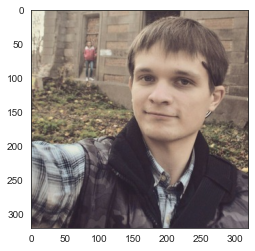

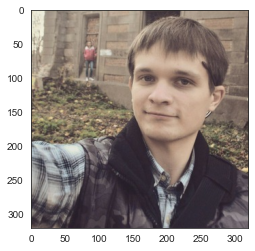

python: [[ -94.90068    88.836296 -479.563   ]]
keras2cpp data\my.model data\test.npy
c++: 


1

In [49]:
#@title Тест предсказания с с++
fname = 'C:\\Users\\User\\Desktop\\i99QImnBxBCkQysBLX61ECM2GHBWjhEHJdwGV_1pSMPCpRqfRMj2IYcPO7Ls4VKhJaUSxvzwV_gjfk8rEjxMJ2yMmo_cA3OUPjNr24UtvP41VjEL18ELs0ya2gHh5Jq9R2-omZ1-29x_ze4RQWOnH6xM8F9xK4Ozqmxt_THxLq0A5Mhbf6ICsASfEytrmK_dB8WBOiwLp428s1bTTJPEvOFtq.jpg'
test_npy = DATA_PATH + os.path.sep+ 'test'
arr = Image.open(fname)
arr = arr.convert('RGB')
sns.set_style('white')
plt.imshow(arr)
plt.show()

k = arr.size[0]/arr.size[1] 
if k <= 0.9 or k >= 1.1:
    x = crop_img(arr)
else:
    x = extend_img(arr)
x = x/255.
np.save(test_npy, x)
    
x = np.load(f'{test_npy}.npy')
plt.imshow(x)
plt.show()

x.resize(1, *SHAPE_IN)
print('python:', enc.predict(x)) 

cmd = f'keras2cpp {my_model} {test_npy}.npy'
print(cmd)
process = os.popen(cmd)
print('c++:', process.read())
process.close()            

In [45]:
#@title Экспорт тестовых фото
if os.path.isfile(DATA_PATH+os.path.sep+'fake.csv'):
    os.remove(DATA_PATH+os.path.sep+'fake.csv')
with open(os.path.join(DATA_PATH, 'data.json'), 'r') as fp:
    test_act = json.load(fp)['test']
list_dirs = [os.path.join(NORM_PATH, a) for a in test_act]
j = 0
for num_actor, actor in tqdm(enumerate(list_dirs)):
    for i, fname in enumerate(os.listdir(actor)):
        fname = os.path.join(actor, fname)
        x = Image.open(fname)
        x = x.convert('RGB')
        x = np.array(x)
        x.resize(1, *SHAPE_IN)
        p = enc.predict(x)
    
        name = f'{os.path.basename(actor)}_{i+1:04d}.webp'
        with open(DATA_PATH+os.path.sep+'fake.csv', 'a') as f:
            f.write(f'"{j+1}","-{num_actor+1}","fake/{name}","%s","%s","%s","1",,,\n' % (*p[0],)) 
   
        #jpg = Image.open(fname)
        #jpg = jpg.resize((160,160), Image.ANTIALIAS)
        #jpg.save(os.path.join(PATH_EXP, name), format="webp") 
        j += 1
print('test image count', j)

26it [01:41,  3.91s/it]

test image count 2293


## Результат

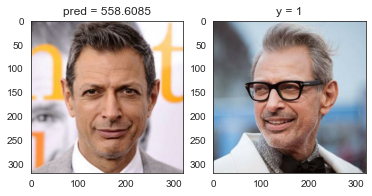

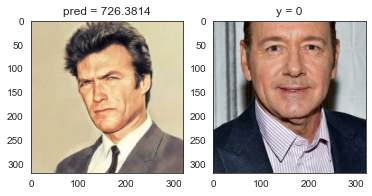

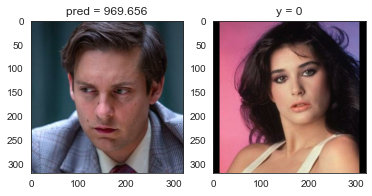

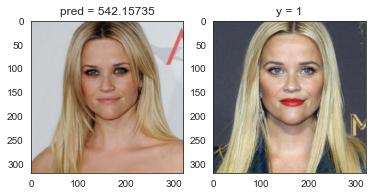

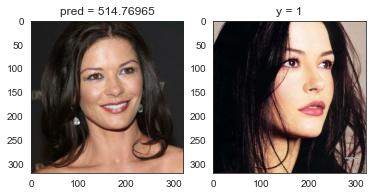

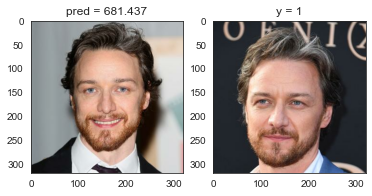

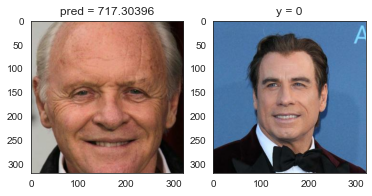

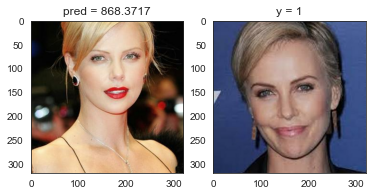

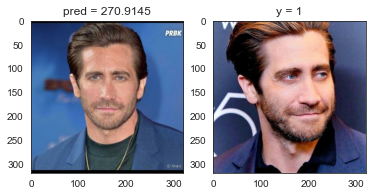

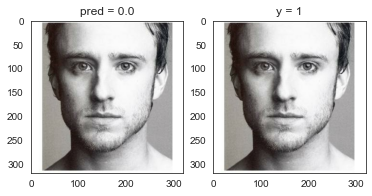

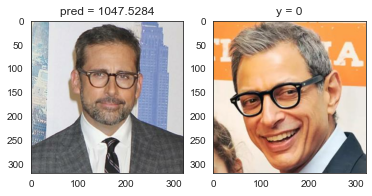

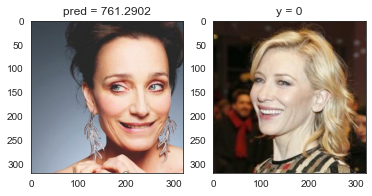

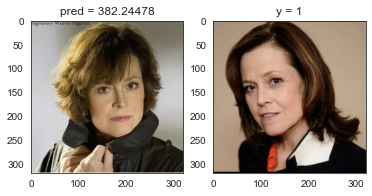

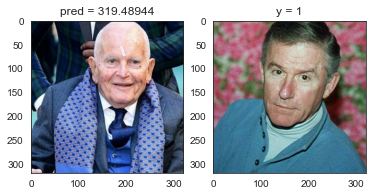

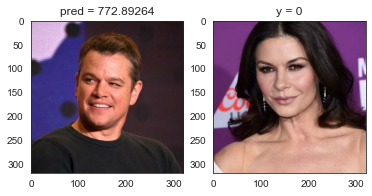

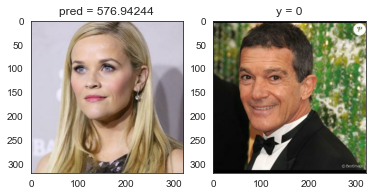

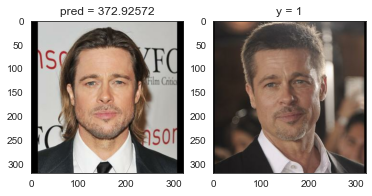

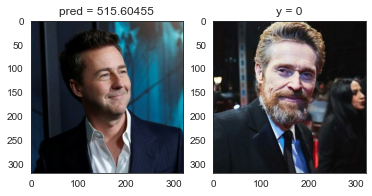

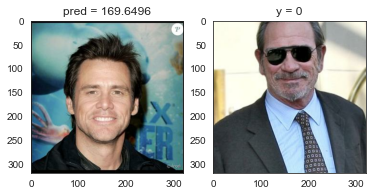

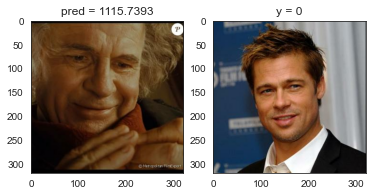

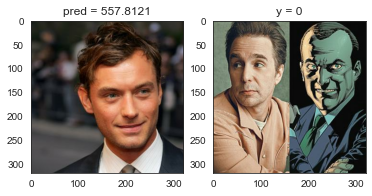

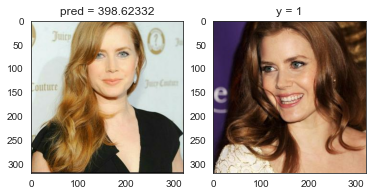

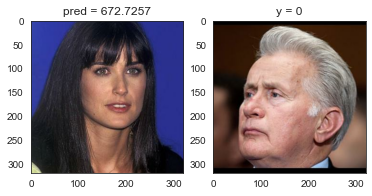

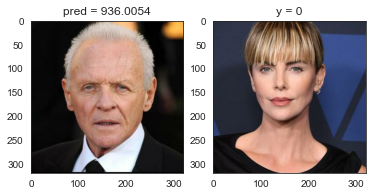

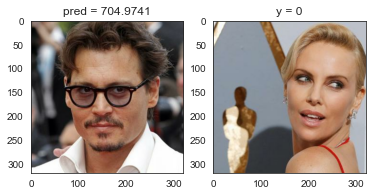

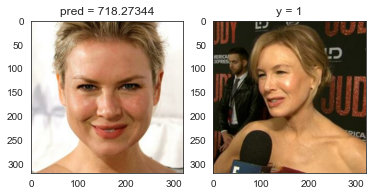

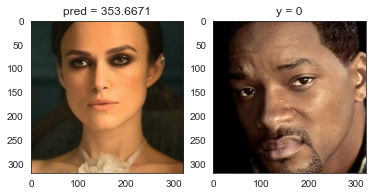

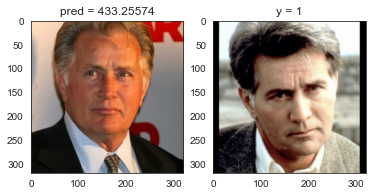

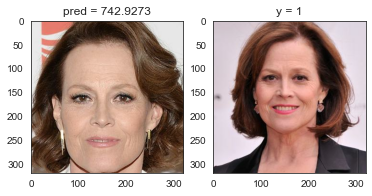

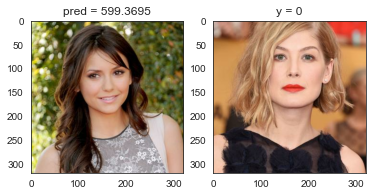

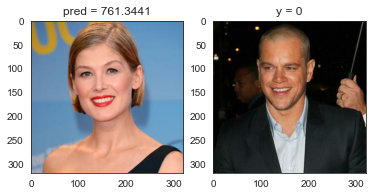

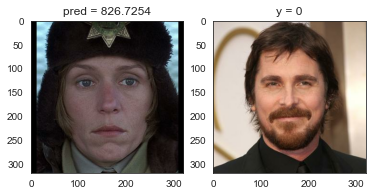

In [47]:
#@title Точность сети
iter_test = iter(valid_gen)
(a, b), y = next(iter_test)
y = y.numpy().ravel()
pred = siam.predict([a, b]).ravel()
count_true = 0
for i in range(len(y)):
    count_true += (y[i] == 1 and pred[i] >= .5) or (y[i] == 0 and pred[i] < .5)
    plt.subplot(121)
    plt.title('pred = %s' % pred[i])
    plt.imshow(a[i])
    plt.subplot(122)
    plt.imshow(b[i])
    plt.title('y = %s' % int(y[i]))
    plt.show()

In [48]:
count_true/len(y)

0.40625